In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import json
import torch

from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

from pnr_utils import *
from pnr_models import *

seed = 12
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
np.random.seed(seed)

### Load and process synthetic data

- Input the **sample name** and the **set number** of the dataset generated by `pnr_generate.py` to locate the appropriate directories and read the metadata.


- Load and process (apply noise, smoothing, and normalization to) spectra and identify the parameter names (y_header) and corresponding indices (y_ids) to use for supervised learning.


- Standardize y-data (parameter values), perform train/valid/test split stratified by class, and convert data to torch tensors.

In [2]:
# set data properties
sample_name = 'BiSe10_EuS5' #CrO20_BiSbTe20
dataset = 0

# get directories
set_dir = 'results/' + sample_name + '/set_' + str(dataset)
data_dir = set_dir + '/data'

# parse metadata and experiment files
layers, N, q_min, q_max = parse_metadata(set_dir)
q = 10*np.linspace(q_min, q_max, N)
exp_names = next(os.walk('experiments/' + sample_name))[1]
exp_names = [sample_name + '/' + exp_names[j] for j in np.argsort([int(i[:i.index('K')]) for i in exp_names])]

print('set directory:', set_dir)

set directory: results/BiSe10_EuS5/set_0


In [3]:
# load and process data
x_data, x_orig, x_moms, y_data, y_columns, y_header, y_ids, y_labels, y_units = process_data(data_dir, sample_name,
                                                                                             exp_names[0], q, seed)

# standardize data
scaler = StandardScaler().fit(y_data[:,np.array(y_ids[:-1])])
y_data[:,np.array(y_ids[:-1])] = scaler.transform(y_data[:,np.array(y_ids[:-1])])

# split data
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(x_data, y_data, seed)

train size: 67000 positive examples: 33328 negative examples: 33672
valid size: 16500 positive examples: 8208 negative examples: 8292
test size: 16500 positive examples: 8208 negative examples: 8292


In [4]:
# convert to torch tensors
x_train = torch.from_numpy(x_train).unsqueeze(1)
x_valid = torch.from_numpy(x_valid).unsqueeze(1)
x_test = torch.from_numpy(x_test).unsqueeze(1)
y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)
y_test = torch.from_numpy(y_test)

height = x_train.size()[2]
width = x_train.size()[3]
num_features = len(y_ids) - 1

### Define model

- Input the **model name** (vae, cvae, rvae) for the model to train according to:
    * vae: simple VAE with no classifier or regressors
    * cvae: VAE + classifier
    * rvae: CVAE + regressors for each parameter value


- Input the **model number** to resume training (or to continue analysis without further fitting), or -1 to start a new fit.


- Input the number of models (**reps**) to train in succession, and set the **batch size** and number of **epochs**.


- Set **z_std_norm** to False if z_mean is presumed to match the parameter values, or True if presumed to be 0, and set the parameters defining the model architecture.

In [5]:
# model to train
model_name = 'cvae'
model_num = 3           # -1 to start a new fit, model number to resume or analyze

# training parameters
reps = 1
batch_size = 256
epochs = 100

# model parameters
z_std_norm = False       # True if z ~ N(0,1), False if z ~ N(mu,1), mu > 0
kwargs = {
    'hidden_dim': 256,
    'latent_dim': num_features,
    'start_filters': 8,
    'kernel_size': 7,
    'pool_size': 4,
    'num_conv': 2,
    'num_dense': 5,
    'slope': 0.3,
    'drop': False,
    'beta_1': 0.1,
    'beta_2': 1.
}

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
# set model directories
model_prefix = '/' + model_name + '_'
resume_fit = model_num >= 0

if resume_fit:
    # load args from saved model directory
    model_dir = set_dir + model_prefix + str(model_num)
    args = torch.load(model_dir + '/model_0/model.torch')['args']
    start_epoch = args['epochs']
    epochs = start_epoch + epochs
    args['epochs'] = epochs
    
    kwargs = args['kwargs']
    
else:
    # create new model directory
    args = {}
    dirs = next(os.walk(set_dir))[1]
    for k in dirs:
        if k.startswith('.'): dirs.remove(k)
    dirs.remove('data')
    if 'properties' in dirs: dirs.remove('properties')

    if len(dirs):
        idns = [int(d.split('_')[-1]) for d in dirs]
        idn = max(idns) + 1
        args['model_num'] = idn
        model_dir = set_dir + model_prefix + str(idn)
    else:
        args['model_num'] = 0
        model_dir = set_dir + model_prefix + '0'

    os.makedirs(model_dir)
    start_epoch = 0
    
    # save arguments
    args['batch_size'] = batch_size
    args['reps'] = reps
    args['epochs'] = epochs
    args['z_std_norm'] = z_std_norm
    args['kwargs'] = kwargs

meta = json.dumps(args, sort_keys=True, indent=2)
with open(model_dir + '/args.txt', 'w') as f:
    f.write(meta)

print('model directory:', model_dir)

model directory: results/BiSe10_EuS5/set_0/cvae_3


In [7]:
# configure data loaders
data_train = TensorDataset(x_train, y_train)
data_valid = TensorDataset(x_valid, y_valid)
data_test = TensorDataset(x_test, y_test)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(data_valid, batch_size=batch_size)
test_loader = DataLoader(data_test, batch_size=batch_size)

d_sets = ['train', 'valid', 'test']
data_loaders = dict(zip(d_sets, [DataLoader(data_train, batch_size=batch_size), valid_loader, test_loader]))

### Train model

- Train reps number of models in succession.

In [22]:
for r in range(reps):
    image_dir = model_dir + '/model_' + str(r)
    if not os.path.exists(image_dir): os.makedirs(image_dir)

    model, opt, metric_keys = init_model(model_name, height, width, num_features, kwargs, device)
    if r == 0: print(model)

    print('====== repetition:', r)

    if resume_fit:
        model.load_state_dict(torch.load(image_dir + '/model.torch')['state'])
        opt.load_state_dict(torch.load(image_dir + '/model.torch')['optimizer'])
        dynamics = torch.load(image_dir + '/model.torch')['dynamics']
    else: dynamics = []

    for epoch in range(start_epoch + 1, epochs + 1):
        train_metrics = train(epoch, model, opt, metric_keys, train_loader, device, model_name, z_std_norm, y_ids) 
        valid_metrics = evaluate(epoch, model, metric_keys, train_loader, device, model_name, z_std_norm, y_ids)
        dynamics.append({
            'epoch': epoch,
            'train': train_metrics,
            'valid': valid_metrics
        })

    results = {
        'args': args,
        'dynamics': dynamics,
        'state': model.state_dict(),
        'optimizer': opt.state_dict()
    }

    # save data and metadata to .torch dictionary
    with open(image_dir + '/model.torch', 'wb') as f:
        torch.save(results, f)

CVAE(
  (encoder_conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(7, 1), stride=(4, 1), padding=(2, 0))
      (1): LeakyReLU(negative_slope=0.3)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(7, 1), stride=(4, 1), padding=(2, 0))
      (1): LeakyReLU(negative_slope=0.3)
    )
  )
  (encoder_fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.3)
    )
    (4): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0

epoch: 15 train =====   total_loss: 1.66e+00   recon_loss: 5.15e-01   kld_loss: 5.31e+00   label_loss: 7.20e-01   class_loss: 6.24e-01   recon_mse: 1.01e-03   label_mse: 7.20e-01   class_accuracy: 6.43e-01
epoch: 15 valid =====   total_loss: 1.48e+00   recon_loss: 3.38e-01   kld_loss: 5.26e+00   label_loss: 6.95e-01   class_loss: 6.05e-01   recon_mse: 6.61e-04   label_mse: 6.95e-01   class_accuracy: 6.68e-01
epoch: 16 train =====   total_loss: 1.65e+00   recon_loss: 5.05e-01   kld_loss: 5.30e+00   label_loss: 7.15e-01   class_loss: 6.02e-01   recon_mse: 9.86e-04   label_mse: 7.15e-01   class_accuracy: 6.64e-01
epoch: 16 valid =====   total_loss: 1.45e+00   recon_loss: 3.14e-01   kld_loss: 5.37e+00   label_loss: 7.14e-01   class_loss: 5.87e-01   recon_mse: 6.13e-04   label_mse: 7.14e-01   class_accuracy: 6.80e-01
epoch: 17 train =====   total_loss: 1.66e+00   recon_loss: 5.01e-01   kld_loss: 5.32e+00   label_loss: 7.13e-01   class_loss: 5.83e-01   recon_mse: 9.78e-04   label_mse: 7.13e-

epoch: 35 train =====   total_loss: 1.53e+00   recon_loss: 4.38e-01   kld_loss: 4.87e+00   label_loss: 5.88e-01   class_loss: 4.24e-01   recon_mse: 8.56e-04   label_mse: 5.88e-01   class_accuracy: 7.94e-01
epoch: 35 valid =====   total_loss: 1.32e+00   recon_loss: 2.44e-01   kld_loss: 4.87e+00   label_loss: 5.86e-01   class_loss: 4.10e-01   recon_mse: 4.77e-04   label_mse: 5.86e-01   class_accuracy: 8.01e-01
epoch: 36 train =====   total_loss: 1.54e+00   recon_loss: 4.37e-01   kld_loss: 4.85e+00   label_loss: 5.85e-01   class_loss: 4.19e-01   recon_mse: 8.54e-04   label_mse: 5.85e-01   class_accuracy: 7.96e-01
epoch: 36 valid =====   total_loss: 1.34e+00   recon_loss: 2.41e-01   kld_loss: 4.86e+00   label_loss: 5.82e-01   class_loss: 3.89e-01   recon_mse: 4.71e-04   label_mse: 5.82e-01   class_accuracy: 8.16e-01
epoch: 37 train =====   total_loss: 1.50e+00   recon_loss: 4.35e-01   kld_loss: 4.85e+00   label_loss: 5.84e-01   class_loss: 4.19e-01   recon_mse: 8.49e-04   label_mse: 5.84e-

epoch: 55 train =====   total_loss: 1.48e+00   recon_loss: 4.18e-01   kld_loss: 4.46e+00   label_loss: 4.94e-01   class_loss: 3.64e-01   recon_mse: 8.17e-04   label_mse: 4.94e-01   class_accuracy: 8.28e-01
epoch: 55 valid =====   total_loss: 1.29e+00   recon_loss: 2.23e-01   kld_loss: 4.48e+00   label_loss: 5.00e-01   class_loss: 3.47e-01   recon_mse: 4.35e-04   label_mse: 5.00e-01   class_accuracy: 8.37e-01
epoch: 56 train =====   total_loss: 1.48e+00   recon_loss: 4.18e-01   kld_loss: 4.45e+00   label_loss: 4.92e-01   class_loss: 3.67e-01   recon_mse: 8.17e-04   label_mse: 4.92e-01   class_accuracy: 8.27e-01
epoch: 56 valid =====   total_loss: 1.28e+00   recon_loss: 2.22e-01   kld_loss: 4.43e+00   label_loss: 4.85e-01   class_loss: 3.68e-01   recon_mse: 4.34e-04   label_mse: 4.85e-01   class_accuracy: 8.25e-01
epoch: 57 train =====   total_loss: 1.44e+00   recon_loss: 4.17e-01   kld_loss: 4.43e+00   label_loss: 4.90e-01   class_loss: 3.60e-01   recon_mse: 8.15e-04   label_mse: 4.90e-

epoch: 75 train =====   total_loss: 1.43e+00   recon_loss: 4.07e-01   kld_loss: 4.39e+00   label_loss: 4.75e-01   class_loss: 3.27e-01   recon_mse: 7.95e-04   label_mse: 4.75e-01   class_accuracy: 8.48e-01
epoch: 75 valid =====   total_loss: 1.25e+00   recon_loss: 2.02e-01   kld_loss: 4.41e+00   label_loss: 4.72e-01   class_loss: 3.13e-01   recon_mse: 3.95e-04   label_mse: 4.72e-01   class_accuracy: 8.56e-01
epoch: 76 train =====   total_loss: 1.45e+00   recon_loss: 4.06e-01   kld_loss: 4.39e+00   label_loss: 4.73e-01   class_loss: 3.27e-01   recon_mse: 7.93e-04   label_mse: 4.73e-01   class_accuracy: 8.49e-01
epoch: 76 valid =====   total_loss: 1.26e+00   recon_loss: 2.04e-01   kld_loss: 4.35e+00   label_loss: 4.62e-01   class_loss: 2.93e-01   recon_mse: 3.99e-04   label_mse: 4.62e-01   class_accuracy: 8.68e-01
epoch: 77 train =====   total_loss: 1.46e+00   recon_loss: 4.06e-01   kld_loss: 4.39e+00   label_loss: 4.72e-01   class_loss: 3.24e-01   recon_mse: 7.92e-04   label_mse: 4.72e-

epoch: 95 train =====   total_loss: 1.41e+00   recon_loss: 3.99e-01   kld_loss: 4.14e+00   label_loss: 4.18e-01   class_loss: 3.00e-01   recon_mse: 7.80e-04   label_mse: 4.18e-01   class_accuracy: 8.62e-01
epoch: 95 valid =====   total_loss: 1.22e+00   recon_loss: 1.97e-01   kld_loss: 4.14e+00   label_loss: 4.10e-01   class_loss: 2.82e-01   recon_mse: 3.85e-04   label_mse: 4.10e-01   class_accuracy: 8.77e-01
epoch: 96 train =====   total_loss: 1.40e+00   recon_loss: 4.02e-01   kld_loss: 4.11e+00   label_loss: 4.13e-01   class_loss: 2.97e-01   recon_mse: 7.86e-04   label_mse: 4.13e-01   class_accuracy: 8.64e-01
epoch: 96 valid =====   total_loss: 1.23e+00   recon_loss: 2.02e-01   kld_loss: 4.11e+00   label_loss: 4.12e-01   class_loss: 2.92e-01   recon_mse: 3.94e-04   label_mse: 4.12e-01   class_accuracy: 8.66e-01
epoch: 97 train =====   total_loss: 1.41e+00   recon_loss: 3.99e-01   kld_loss: 4.11e+00   label_loss: 4.14e-01   class_loss: 3.00e-01   recon_mse: 7.79e-04   label_mse: 4.14e-

### Evaluate a representative model

- Input the **repetition** to load the corresponding trained model.


- Load and process the experimental data.


- Plot the training history.


- Make predictions on all synthetic and experimental data.


- Plot example reconstructions of synthetic data in each error quartile, and reconstructions of experimental data.


- Visualize the latent space according to y-values along 2 dimensions.


- Plot performance of regressors, if present.


- Find the optimal threshold for classifier and plot classifier performance, if present.

In [8]:
# repetition to evaluate
r = 0
image_dir = model_dir + '/model_' + str(r)
model, _, _ = init_model(model_name, height, width, num_features, kwargs, device)
model.load_state_dict(torch.load(image_dir + '/model.torch')['state'])

# process experiment
x_exp = process_exp(exp_names, q, x_moms)
x_exp = torch.from_numpy(x_exp).unsqueeze(1)

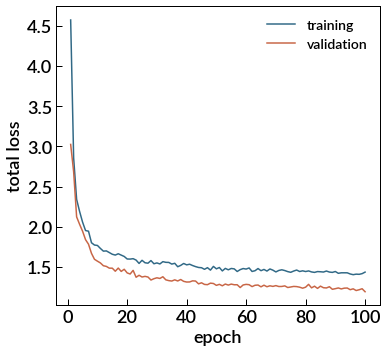

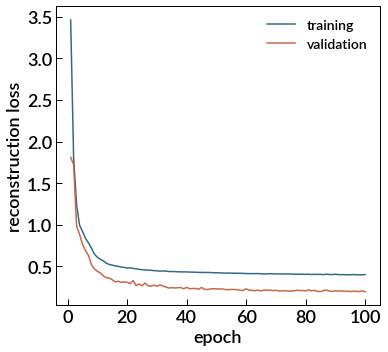

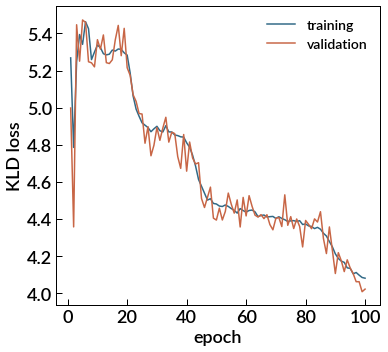

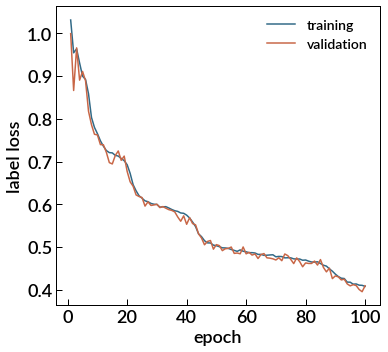

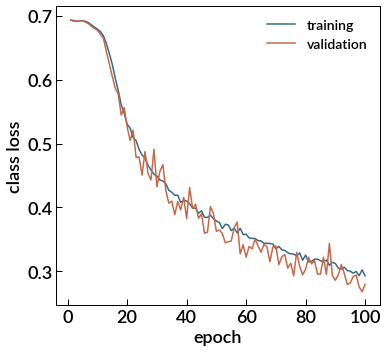

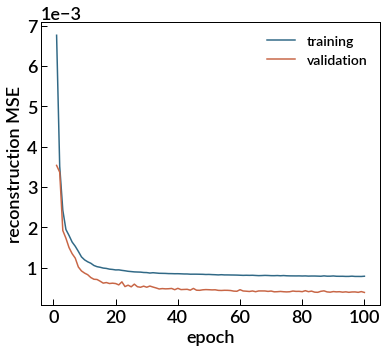

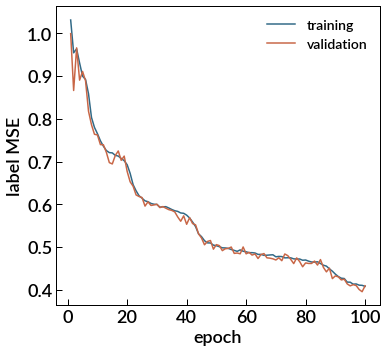

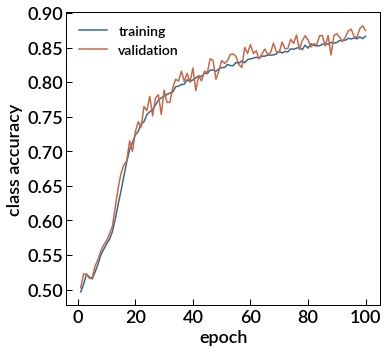

In [9]:
# plot training history
dynamics = torch.load(image_dir + '/model.torch')['dynamics']
plot_history(image_dir, dynamics, logscale=False)

In [10]:
# predict on synthetic data
df = get_predictions(model, data_loaders, d_sets, device, height, width, num_features, kwargs, model_name, z_std_norm,
                     y_ids, scaler)

In [11]:
# predict on experimental data
df_exp = get_predictions_exp(model, x_exp, exp_names, device, height, width, num_features, kwargs, model_name,
                             z_std_norm, scaler)

In [12]:
# print predictions of i_th experiment
i = 0
print('experiment:', exp_names[i])
if model_name == 'rvae':
    dict_exp = dict(zip(y_header + ['class'], df_exp.iloc[i]['y_pred']))
    print(dict_exp)
    
elif model_name == 'cvae':
    dict_exp = dict(zip(y_header, df_exp.iloc[i]['z']))
    dict_exp['class_prox'] = df_exp.iloc[i]['y_pred'][0]
    print(dict_exp)

else:
    if not z_std_norm:
        dict_exp = dict(zip(y_header, df_exp.iloc[i]['z']))
        print(dict_exp)

experiment: BiSe10_EuS5/4K
{'dens_sub': 22.823738154058127, 'dens_TI': 6.37078670277956, 'dens_FM': 19.29496940688578, 'dens_cap': 16.763799822476248, 'd_TI': 8.13634226883878, 'd_prox': 0.7145184262737969, 'd_FM': 5.339344878601044, 'd_cap': 8.58081553575461, 'magn_prox': 1.5332599795654838, 'magn_FM': 7.429374488696366, 'class_prox': 0.5360517357518673}


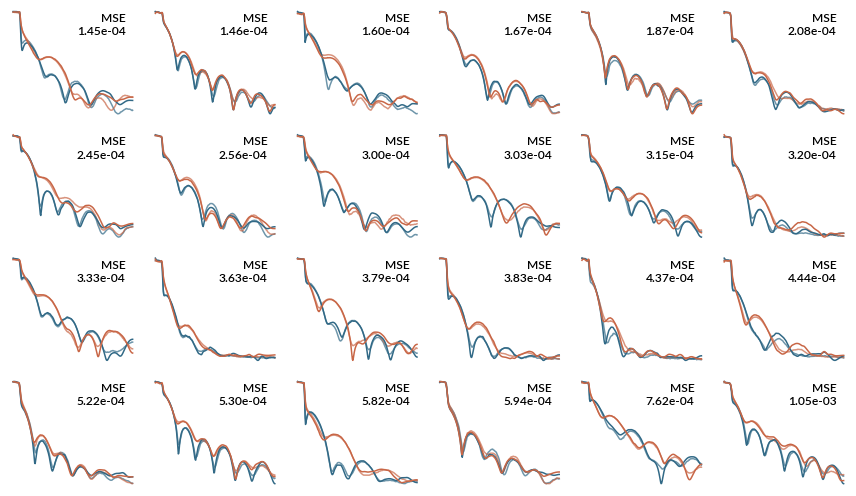

In [13]:
# plot example reconstructions
plot_decoded(image_dir, np.stack(df.loc[df['set']=='test', 'x_pred'].values),
             np.stack(df.loc[df['set']=='test', 'x_true'].values),
             np.stack(df.loc[df['set']=='test', 'x_mse'].values), 'test')

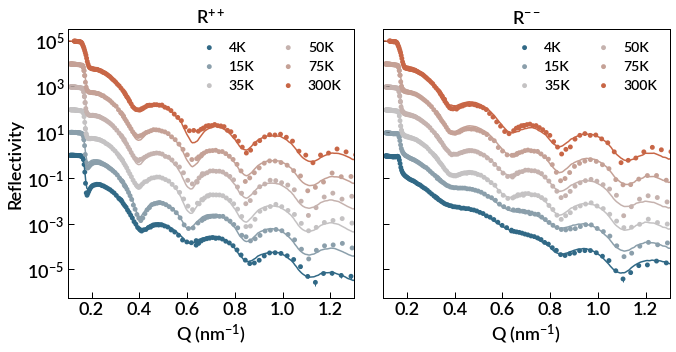

In [14]:
# plot reconstructed experiment
plot_decoded_exp(image_dir, np.stack(df_exp['x_pred'].values), exp_names, q, x_moms)

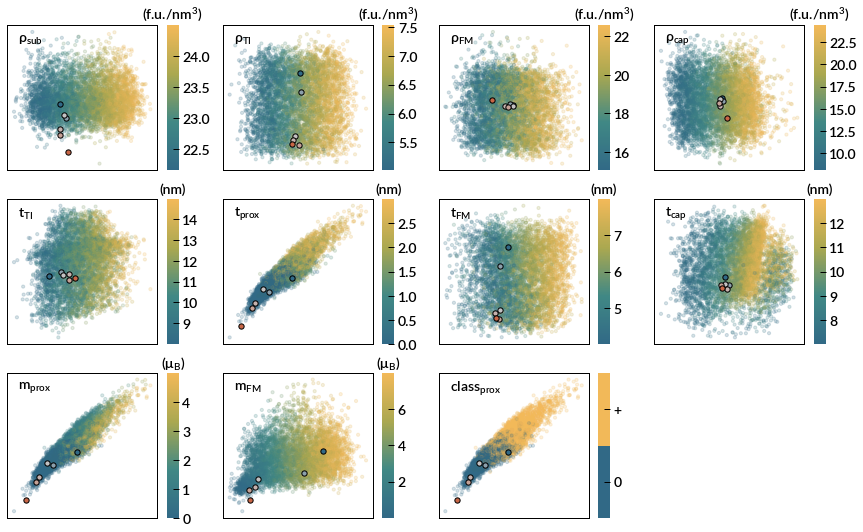

In [30]:
# visualize separability of latent space
plot_latent_representation(image_dir, np.stack(df.loc[df['set']=='test', 'z'].values),
                           np.stack(df.loc[df['set']=='test', 'y_true'].values),
                           y_ids, y_labels, y_units, 'encoded_test', np.stack(df_exp['z'].values), exp_names)

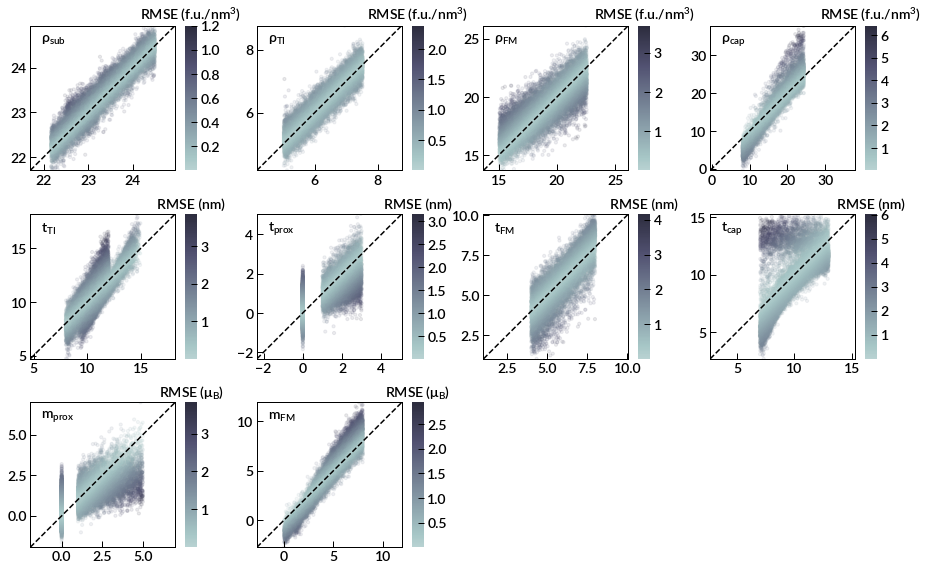

In [29]:
# plot regressor performance
if (model_name == 'rvae'):
    plot_predicted(image_dir, np.stack(df.loc[df['set']=='test', 'y_pred'].values)[:,:-1],
               np.stack(df.loc[df['set']=='test', 'y_true'].values),
               np.stack(df.loc[df['set']=='test', 'y_mse'].values), y_ids, y_labels, y_units)

else:
    if not z_std_norm:
        plot_predicted(image_dir, np.stack(df.loc[df['set']=='test', 'z'].values),
                       np.stack(df.loc[df['set']=='test', 'y_true'].values),
                       np.stack(df.loc[df['set']=='test', 'z_mse'].values), y_ids, y_labels, y_units)

tpr: 0.829556530214425 fpr: 0.17040520984081042 threshold: 0.3883458212413423


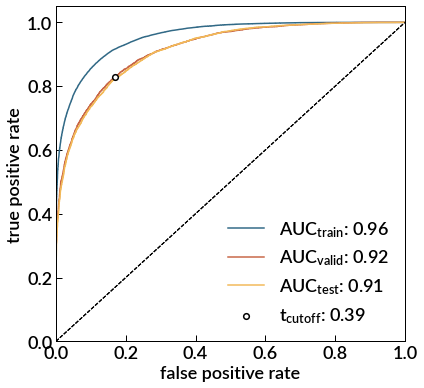

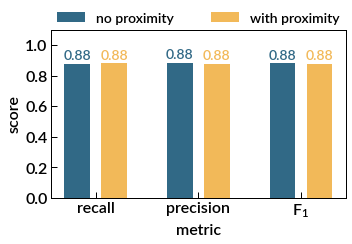

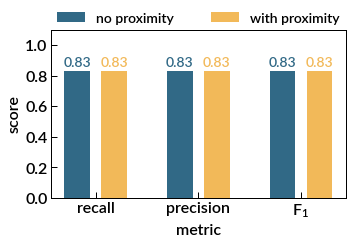

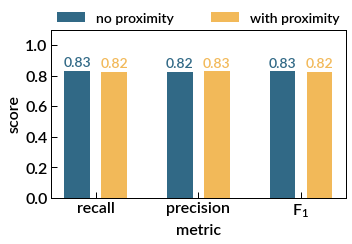

In [32]:
# find optimal threshold and plot classifier performance
if (model_name == 'rvae') or (model_name == 'cvae'):
    fpr, tpr, roc_auc, th = get_roc(df, d_sets)
    tpr0, fpr0, th = get_optimal_threshold(fpr[1], tpr[1], th[1])

    plot_roc(image_dir, fpr, tpr, roc_auc, [tpr0, fpr0, th])
    plot_precision_recall_f1(image_dir, df, d_sets, th)

### Other

- For rvae model only, invert the weight matrix mapping z to the parameter values, which can be used to input known parameter values to get z and then decode spectrum.

In [ ]:
# get reflectivity given input parameters (rvae only)
if model_name == 'rvae':
    U = np.zeros((num_features, num_features))
    for i in range(num_features):
        U[i,:] = getattr(model, "reg_%d"%i).weight.detach().cpu()
    _U = np.linalg.inv(U)

    z_example = np.dot(_U, y_test[0, y_ids[:-1]].numpy())
    z_example = torch.from_numpy(z_example).unsqueeze(0).to(device)
    x_example = model.decode(z_example).squeeze().detach().cpu().numpy()

    prop.set_size(18)
    lprop = prop.copy()
    lprop.set_size(14)
    fig, ax = plt.subplots(figsize=(5.5,5))
    ax.plot(q, normalize_log_inverse(x_example[:,0], x_moms), color='#316986', label='R$^{++}$')
    ax.plot(q, normalize_log_inverse(x_example[:,1], x_moms), color='#C86646', label='R$^{--}$')
    ax.set_yscale('log')
    format_axis(ax, 'Q (nm$^{-1}$)', 'Reflectivity', prop)
    ax.legend(prop=lprop, edgecolor='white', framealpha=1, loc='upper right');

### Evaluate all models

- Compile the training history and experiment predictions on all model repetitions.


- Plot the training history statistics.


- Plot classification statistics on experimental data.

In [ ]:
# predict on all models to compute statistics
dynamics, ths = [], []
for r in range(reps):
    image_dir = model_dir + '/model_' + str(r)
    model, _, _ = init_model(model_name, height, width, num_features, kwargs, device)
    model.load_state_dict(torch.load(image_dir + '/model.torch')['state'])
    
    # plot training history
    dynamics += [torch.load(image_dir + '/model.torch')['dynamics']]
    
    # predict on synthetic data
    df = get_predictions(model, data_loaders, d_sets, device, height, width, num_features, kwargs, model_name,
                         z_std_norm, y_ids, scaler)
    
    # get optimal threshold
    if (model_name == 'rvae') or (model_name == 'cvae'):
        fpr, tpr, _, th = get_roc(df, d_sets)
        _, _, th = get_optimal_threshold(fpr[1], tpr[1], th[1])
        ths += [th]
        
    # predict on experimental data
    if r > 0:
        df = get_predictions_exp(model, x_exp, exp_names, device, height, width, num_features, kwargs, model_name,
                                 z_std_norm, scaler)
        df['model'] = r
        df['th'] = th
        df_exp = df_exp.append(df, ignore_index=True)
    else:
        df_exp = get_predictions_exp(model, x_exp, exp_names, device, height, width, num_features, kwargs, model_name,
                                     z_std_norm, scaler)
        df_exp['model'] = r
        df_exp['th'] = th

In [ ]:
# plot training history statistics
plot_history_statistics(model_dir, dynamics, logscale=False)

In [ ]:
# plot class statistics on experimental sample
plot_class_exp_statistics(df_exp)